# Book Recommendations

Every user has some preferences in relation to items offered by the service. It is possible to infer these preferences based on a variety of attributes (examples with books): book page view time, book clicks, adding to favorites, rating, writing reviews, and so on. 

All interactions between users and items can be converted to numbers and stored in so-called user-item interactions matrix. Here is an example from [this article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada):

![Interactions](pics/interactions.png "Interactions image")

The purpose of recommendation systems is to predict ratings which a user would give to items that he has not rated yet. In a simple way, the recommender algorithms can be classified as follows (the picture from the same [article](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada)):

![Recommender classification](pics/recommender_classification.png "Recommender classification image")

A typical difficulty in building recommender systems is the small number of ratings. Thus, to mitigate this problem, we will combine information from [Book–Crossing](book_crossing/data_prep) and [Goodreads](goodreads/data_prep) datasets.

In [1]:
import os
import pickle
import warnings
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import tensorflow as tf
from dotenv import load_dotenv
from pandas.api.types import CategoricalDtype
from scipy.sparse import coo_matrix, find
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

from models.gradient_descent import RecommenderGD
from models.svd import RecommenderSVD

# Load environment variables
load_dotenv()

# Set random seeds and supress warnings
RANDOM_SEED = int(os.environ['RANDOM_SEED'])
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Preparation

## Book Crossing

Load preprocessed Book–Crossing data:

In [2]:
path_bc = os.path.join('book_crossing', 'data_prep')
books_bc = pd.read_csv(os.path.join(path_bc, 'books.csv'),
                       usecols=['isbn13', 'book_title'],
                       index_col=['isbn13'],
                       dtype={'isbn13': 'category',
                              'book_title': 'str'})
ratings_bc = pd.read_csv(os.path.join(path_bc, 'ratings.csv'),
                         dtype={'user_id': 'category',
                                'rating': 'uint8',
                                'isbn13': 'category'})

In [3]:
books_bc.head(3)

,book_title
isbn13,
9780195153446,Classical Mythology
9780002005012,Clara Callan
9780060973124,Decision in Normandy


In [4]:
# Drop all implicit ratings
ratings_bc = ratings_bc[ratings_bc['rating'] > 0]
ratings_bc.head(3)

,user_id,rating,isbn13
1,276726,5,9780155061224
3,276729,3,9780521656153
4,276729,6,9780521795029


In [5]:
print(f'Number of books: {len(books_bc)}')
print(f'Number of ratings: {len(ratings_bc)}')

Number of books: 270947
Number of ratings: 384127


In [6]:
books_bc.rename(columns={'book_title': 'title'},
                inplace=True)
books_bc.head(2)

,title
isbn13,
9780195153446,Classical Mythology
9780002005012,Clara Callan


## Goodreads

Load preprocessed Goodreads data:

In [7]:
path_gr = os.path.join('goodreads', 'data_prep')
books_gr = pd.read_csv(os.path.join(path_gr, 'books.csv'),
                       usecols=['isbn13', 'title', 'work_id', 'book_id'],
                       index_col=['book_id'],
                       dtype={'isbn13': 'category', 'work_id': 'category',
                              'title': 'str', 'book_id': 'category'})
ratings_gr = pd.read_csv(os.path.join(path_gr, 'ratings.csv'),
                         usecols=['user_id', 'book_id', 'rating'],
                         dtype={'user_id': 'category',
                                'rating': 'float16',
                                'book_id': 'category'})

In [8]:
books_gr.head(3)

,isbn13,work_id,title
book_id,,,
5333265,9780312853129,5400751,W.C. Fields: A Life on Film
1333909,9780743509985,1323437,Good Harbor
6066819,9780743294294,6243154,Best Friends Forever


In [9]:
# Drop all implicit ratings
ratings_gr = ratings_gr[~ratings_gr['rating'].isna()]
ratings_gr['rating'] = ratings_gr['rating'].astype('uint8')
ratings_gr.head(3)

,rating,book_id,user_id
0,5,12,8842281e1d1347389f2ab93d60773d4d
1,5,21,8842281e1d1347389f2ab93d60773d4d
2,5,30,8842281e1d1347389f2ab93d60773d4d


In [10]:
print(f'Number of books: {len(books_gr)}')
print(f'Number of ratings: {len(ratings_gr)}')

Number of books: 1599130
Number of ratings: 89625534


As we remember from the data preprocessing stage, there are some duplicated ISBNs:

In [11]:
books_gr_duplicates = books_gr[books_gr.duplicated(['isbn13'], keep=False)]\
    .sort_values('isbn13')
books_gr_duplicates.head(5)

,isbn13,work_id,title
book_id,,,
26812295,9780007255764,19269242,The Year of Reading Dangerously: How Fifty Gre...
25412569,9780007255764,19269242,The Year of Reading Dangerously: How Fifty Gre...
25401812,9780007282586,2288775,"A Murder Is Announced (Miss Marple, #5)"
25386782,9780007282586,2288775,A Murder Is Announced
13146527,9780007395200,2677305,Number the Stars


We have to delete the duplicates and made the corresponding changes in the rating dataset:

In [12]:
# Group them and get indexes
books_gr_duplicates_idx = books_gr_duplicates\
    .groupby(['isbn13'], observed=True)\
    .apply(lambda x: list(x.index)).tolist()

# Iterate over each group and keep only one book id
to_replace = {}
for book_group in books_gr_duplicates_idx:
    to_leave = book_group.pop()
    for index in book_group:
        to_replace[index] = to_leave

# Drop duplicates from the book dataset
books_gr.drop(index=to_replace.keys(), inplace=True)

# Replace in the ratings
ratings_gr['book_id'] = ratings_gr['book_id']\
    .map(lambda x: to_replace.get(x, x))

This transformation causes duplicated rows in ratings, so we will drop them:

In [13]:
ratings_gr.drop_duplicates(['user_id', 'book_id'],
                           keep='first', inplace=True)

Change `book_id` to `isbn13`:

In [14]:
ratings_gr = ratings_gr.merge(books_gr[['isbn13']], left_on='book_id',
                              right_index=True, how='left')
ratings_gr.drop(columns=['book_id'], inplace=True)
ratings_gr.head(2)

,rating,user_id,isbn13
0,5,8842281e1d1347389f2ab93d60773d4d,9780517226957
1,5,8842281e1d1347389f2ab93d60773d4d,9780767908184


## Join

Combine book info:

In [15]:
books = books_gr.merge(books_bc, left_on='isbn13',
                       right_index=True, how='outer')

# Merge titles
books['title'] = books['title_x']
missing_titles = books['title'].isna()
books.loc[missing_titles, 'title'] = books.loc[missing_titles, 'title_y']

# Drop unused columns
books.drop(columns=['title_x', 'title_y'], inplace=True)

# Set ISBN as index
books.set_index('isbn13', inplace=True)

Since books from Book-Crossing dataset have no work ids, we need to create unique ones:

In [16]:
books['work_id'] = books['work_id'].astype('float')
missing_work_ids = books['work_id'].isna()
existing_work_ids = set(books.loc[~missing_work_ids, 'work_id'])

new_work_ids = []
counter = 0
nans_count = missing_work_ids.sum()
while len(new_work_ids) < nans_count:
    if counter not in existing_work_ids:
        new_work_ids.append(counter)
    counter += 1

books.loc[missing_work_ids, 'work_id'] = np.array(new_work_ids)
books['work_id'] = books['work_id'].astype('int').astype('category')
books.head(2)

,work_id,title
isbn13,,
9780312853129,5400751,W.C. Fields: A Life on Film
9780743509985,1323437,Good Harbor


Before merging the rating data, we need to scale ratings to the common range:

In [17]:
# Scale goodreads ratings to the range from 1 to 10
ratings_gr['rating'] *= 2

We assume that users from Goodreads and Book-Crossing communities are completely different. Check the ids to be unique:

In [18]:
ratings_gr['user_id'].isin(ratings_bc['user_id']).any()

False

Append Book-Crossing ratings to Goodreads ones:

In [19]:
ratings = ratings_gr.append(ratings_bc)

# Add work_ids
ratings = ratings.merge(books[['work_id']], how='left',
                        left_on='isbn13', right_index=True)
ratings.head(2)

,rating,user_id,isbn13,work_id
0,10,8842281e1d1347389f2ab93d60773d4d,9780517226957,135328
1,10,8842281e1d1347389f2ab93d60773d4d,9780767908184,2305997


Since people most often rate the book content rather than a particular edition of the book, we will build recommendations using `work_id` instead of `isbn13`.

Some users may have rated different editions of the same book. Let's average their ratings so that there is only one rating per book from each user:

In [20]:
ratings_per_work = ratings[['work_id', 'user_id', 'rating']]\
    .groupby(['work_id', 'user_id'], observed=True).mean()

# Drop duplicated ratings
work_ratings = ratings.drop_duplicates(['user_id', 'work_id'], keep='first')
work_ratings = work_ratings[['user_id', 'work_id']]\
    .merge(ratings_per_work, left_on=['user_id', 'work_id'],
           right_on=['user_id', 'work_id'], how='left')
work_ratings.head(4)

,user_id,work_id,rating
0,8842281e1d1347389f2ab93d60773d4d,135328,10.0
1,8842281e1d1347389f2ab93d60773d4d,2305997,10.0
2,8842281e1d1347389f2ab93d60773d4d,89369,10.0
3,8842281e1d1347389f2ab93d60773d4d,1699340,10.0


In [21]:
# Group data to get statistics
for parameter in ['work_id', 'user_id']:
    ratings_by_param = work_ratings[[parameter, 'rating']]\
        .groupby(parameter, observed=True).count()
    rated_count = len(ratings_by_param)
    five_times_rated_count = (ratings_by_param['rating'] >= 5).sum()
    ten_times_rated_count = (ratings_by_param['rating'] >= 10).sum()
    print(f'Number of {parameter} which have ratings: {rated_count}')
    print(f'Number of {parameter} which have at least 5 ratings: '
          f'{five_times_rated_count}')
    print(f'Number of {parameter} which have at least 10 ratings: '
          f'{ten_times_rated_count}\n')
print(f'Total number of ratings: {len(work_ratings)}')

Number of work_id which have ratings: 1141892
Number of work_id which have at least 5 ratings: 568805
Number of work_id which have at least 10 ratings: 394932

Number of user_id which have ratings: 876176
Number of user_id which have at least 5 ratings: 750186
Number of user_id which have at least 10 ratings: 692320

Total number of ratings: 89686460


## Preprocess

To test the recommender performance, we need to split data into train, validation, and test datasets. We will use information about users who left at least 10 ratings (60% for training, 20% for testing and validation). Since the dataset does not contain rating timestamps, we will split the data in a random way. 

In [22]:
ratings_per_user = work_ratings.groupby('user_id', observed=True)
ratings_per_user_count = ratings_per_user['rating'].count()
min_ten_users = ratings_per_user_count[ratings_per_user_count >= 10].index
print(f'Number of users who left at least ten ratings: '
      f'{len(min_ten_users)} '
      f'({round(len(min_ten_users) * 100 / len(ratings_per_user), 2)}%)')

Number of users who left at least ten ratings: 692320 (79.02%)


In [23]:
# Drop users with a little number of ratings
work_ratings_min_ten = ratings_per_user.filter(lambda x: len(x) >= 10)

# Drop unused books
books = books[books['work_id'].isin(work_ratings_min_ten['work_id'])]

In [24]:
# Split into train, test, and val datasets
work_ratings_train, work_ratings_val = train_test_split(
    work_ratings_min_ten, test_size=0.4, random_state=RANDOM_SEED,
    stratify=work_ratings_min_ten['user_id'])
work_ratings_test, work_ratings_val = train_test_split(
    work_ratings_val, test_size=0.5, random_state=RANDOM_SEED,
    stratify=work_ratings_val['user_id'])

# Show the shape
work_ratings_train.shape, work_ratings_val.shape, work_ratings_test.shape

((53439522, 3), (17813175, 3), (17813174, 3))

After splitting, we can see that some books from test and validation data are absent from the training one. We cannot test performance of the algorithms on these samples. Thus, we have to drop them.

In [25]:
work_ratings_val = work_ratings_val[work_ratings_val['work_id']\
    .isin(work_ratings_train['work_id'])]
work_ratings_test = work_ratings_test[work_ratings_test['work_id']\
    .isin(work_ratings_train['work_id'])]

# Show the shape
work_ratings_train.shape, work_ratings_val.shape, work_ratings_test.shape

((53439522, 3), (17724293, 3), (17723743, 3))

To compare multiple users' scores, we need to normalize them. Because one user may always give high ratings (8 to 10), while another may give all ratings from 6 to 8. However, the tastes of these users may be exactly the same. Thus, we will use StandardScaler:

In [26]:
def fit_user_scalers(ratings: pd.DataFrame) -> Dict[str, Tuple[float, float]]:
    """Get statistics per suer to normalize their ratings.

    :param ratings: all ratings.
    :return: average and standard deviation of users' ratings.
    """
    user_ratings_scalers = {}
    scaler = StandardScaler()
    for user_id, user_data in ratings.groupby('user_id'):
        scaler.fit(user_data[['rating']])
        user_ratings_scalers[user_id] = scaler.scale_, scaler.mean_
    return user_ratings_scalers


def ratings_normalize(user_ratings: pd.Series, user_scale: float,
                      user_mean: float) -> pd.Series:
    """Transform user's ratings.

    :param user_ratings: user's ratings.
    :param user_scale: standard deviation of user's ratings.
    :param user_mean: average of user's ratings.
    :return: transformed values.
    """
    scaler = StandardScaler()
    scaler.scale_ = user_scale
    scaler.mean_ = user_mean
    return scaler.transform(user_ratings.values.reshape(-1, 1)).ravel()

In [27]:
# This should be done only for training dataset
user_ratings_scalers = fit_user_scalers(work_ratings_train)

In [28]:
# Transform all datasets
for dataset in [work_ratings_val, work_ratings_test, work_ratings_train]:
    dataset['rating_scaled'] = dataset.groupby('user_id')['rating']\
        .transform(lambda x: ratings_normalize(x, *user_ratings_scalers[x.name]))

## Save data

We have to save preprocessed data to use it in training scripts:

In [29]:
# Save scaler info
with open(os.path.join('data', 'user_ratings_scalers.pkl'), 'wb') as file:
    pickle.dump(user_ratings_scalers, file)

# Save datasets
work_ratings_train.to_csv(os.path.join('data', 'work_ratings_train.csv'),
                          index=False)
work_ratings_val.to_csv(os.path.join('data', 'work_ratings_val.csv'),
                        index=False)
work_ratings_test.to_csv(os.path.join('data', 'work_ratings_test.csv'),
                         index=False)
books.to_csv(os.path.join('data', 'books.csv'), index=True)

Reload the previously saved data in order to use in this notebook the same data loading pipeline as in the training scripts:

In [2]:
# Load scaler info
with open(os.path.join('data', 'user_ratings_scalers.pkl'), 'rb') as file:
    user_ratings_scalers = pickle.load(file)

# Load datasets
work_ratings_train = pd.read_csv(os.path.join('data', 'work_ratings_train.csv'),
                                 dtype={'rating_scaled': 'float16', 
                                        'rating': 'float16'})
work_ratings_val = pd.read_csv(os.path.join('data', 'work_ratings_val.csv'),
                               dtype={'rating_scaled': 'float16', 
                                      'rating': 'float16'})
work_ratings_test = pd.read_csv(os.path.join('data', 'work_ratings_test.csv'),
                                dtype={'rating_scaled': 'float16', 
                                       'rating': 'float16'})
books = pd.read_csv(os.path.join('data', 'books.csv'), index_col='isbn13')

# Extract categories
work_ratings_train['user_id'] = work_ratings_train['user_id'].astype('category')
work_ratings_train['work_id'] = work_ratings_train['work_id'].astype('category')
user_categories = CategoricalDtype(
    categories=work_ratings_train['user_id'].cat.categories)
item_categories = CategoricalDtype(
    categories=work_ratings_train['work_id'].cat.categories)

# Convert values to categories from train data
work_ratings_val['user_id'] = work_ratings_val['user_id'].astype(user_categories)
work_ratings_test['user_id'] = work_ratings_test['user_id'].astype(user_categories)
work_ratings_val['work_id'] = work_ratings_val['work_id'].astype(item_categories)
work_ratings_test['work_id'] = work_ratings_test['work_id'].astype(item_categories)

# Drop unknown users or items
mask = work_ratings_val['user_id'].isna() | work_ratings_val['work_id'].isna()
work_ratings_val = work_ratings_val[~mask]

# Create interaction matrix
interactions_train = coo_matrix((work_ratings_train['rating_scaled'],
                                 (work_ratings_train['user_id'].cat.codes,
                                  work_ratings_train['work_id'].cat.codes)))
interactions_val = coo_matrix((work_ratings_val['rating_scaled'],
                               (work_ratings_val['user_id'].cat.codes,
                                work_ratings_val['work_id'].cat.codes)))
interactions_test = coo_matrix((work_ratings_test['rating_scaled'],
                                (work_ratings_test['user_id'].cat.codes,
                                 work_ratings_test['work_id'].cat.codes)))

# Collaborative Filtering

This type of recommendation can be obtained only with a certain level of knowledge about user's preferences for items. Collaborative filtering can be implemented using memory-based algorithms and model-based algorithms. 

## Model Based

The model-based approach uses data mining algorithms or machine learning techniques. These methods predict the rating that the user would give to a book. The advantage of the approach is the possibility to reduce the dimensionality of the feature space. Thus, there is no need for resource-intensive computations with sparse matrices.

Here, we will try a model-based matrix factorization algorithm which is based on the idea that the matrix with user ratings `M` can be decomposed into two components. The first matrix `X` will describe user's features, and the second one — `Y` will describe the features of the books:

$$ M \approx X \times Y^T $$

Then the task of training the model is to determine matrices `X` and `Y` so that the difference between the predicted and real ratings was minimal: 

$$\min_{X \in \mathbb R^{m \times d}, Y \in \mathbb R^{n \times d}} \sum_{i, j} (M_{ij} - \langle X_{i}, Y_{j} \rangle)^2$$

where  `m` – number of users, `n` – number of books, `d` – size of book and user embedding. Details can be found [here](https://developers.google.com/machine-learning/recommendation/collaborative/basics). The following image [from here](https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada) presents the idea:

![Matrix factorization](pics/matrix_factorization.png "Matrix factorization image")

### Singular Value Decomposition

The first approach we will try is SVD (Singular Value Decomposition) that decomposes the interaction matrix into three matrices:

$$ M = X \times \Sigma \times Y^T $$

where $\Sigma$ — weights diagonal. The dimension of the latent space is a hyperparameter that should be tuned.

Let's try to build this.

In [3]:
# Train a baseline model
svd_baseline = RecommenderSVD(RANDOM_SEED)
svd_baseline.fit(interactions_train, embed_size=10)

# Extract true values
user_ids_train, item_ids_train, ratings_train_true = find(interactions_train)
user_ids_val, item_ids_val, ratings_val_true = find(interactions_val)
ratings_train_true = ratings_train_true.reshape(-1, 1)
ratings_val_true = ratings_val_true.reshape(-1, 1)

# Predict 
ratings_train_predicts = svd_baseline.predict((user_ids_train, item_ids_train))
ratings_val_predicts = svd_baseline.predict((user_ids_val, item_ids_val))

# Evaluate
print(f'RMSE on the train data: '
      f'{mse(ratings_train_true, ratings_train_predicts, squared=False)}')
print(f'RMSE on the validation data: '
      f'{mse(ratings_val_true, ratings_val_predicts, squared=False)}')

RMSE on the train data: 0.9777280039497352
RMSE on the validation data: 1.0323204293967774


In [4]:
# Save the model
svd_model_path = os.path.join('trained_models', 'svd_baseline.pkl')
with open(svd_model_path, 'wb') as model_file:
    pickle.dump(svd_baseline, model_file)

In [5]:
# Check if the baseline model works better than random embeddings
svd_random = RecommenderSVD()
svd_random._user_embeds = np.random.random(size=svd_baseline._user_embeds.shape)
svd_random._item_embeds = np.random.random(size=svd_baseline._item_embeds.shape)

# Predict 
random_train_predicts = svd_random.predict((user_ids_train, item_ids_train))
random_val_predicts = svd_random.predict((user_ids_val, item_ids_val))

# Evaluate
print(f'RMSE on the train data with random embeddings: '
      f'{mse(ratings_train_true, random_train_predicts, squared=False)}')
print(f'RMSE on the validation data with random embeddings: '
      f'{mse(ratings_val_true, random_val_predicts, squared=False)}')

RMSE on the train data with random embeddings: 2.778924792514173
RMSE on the validation data with random embeddings: 2.7988221171322616


Our model is better. Hope, we are on the right track.

Next, we will tune the embedding size. Since the calculation process long enough, it was executed from this [script](training_scripts/svd.py) and monitored via [neptune.ai](https://neptune.ai/). Metrics for different embedding size are shown below and can be viewed [in the neptune dashboard](https://app.neptune.ai/evgenytsydenov/book-recommender/experiments?split=tbl&dash=charts&viewId=5f4a8005-572a-4055-aaa2-8f825b31ef8d):

![SVD tuning](pics/svd_tuning.png "SVD tuning image")

With increasing of embedding size, the SVD model requires much more RAM and get better results on the training data but does not lead to significant decreasing of validation error. Thus, large embeddings cause overfitting.

In the data we used, there are far more unknown ratings than there are known ones. Thus, the interaction matrix contains a lot of zeros. Since we scaled ratings in the preprocessing stage, zeros in our datasets mean average ratings of each user. This is a good baseline. However, it can be improved if to use user and item biases. More details about this can be found in the book ["Practical Recommender Systems" by Kim Falk](https://www.oreilly.com/library/view/practical-recommender-systems/9781617292705/).

### Gradient Descent

To minimize the difference between predicted and real values of ratings in the equation above, we can use the gradient descent. The method consists in the following steps:

1) Random initialization of user and item embeddings.
2) Compute dot product of embeddings for known user and book pair.
3) Compare predicted value with the real one.
4) Update embeddings to minimize the difference.
5) Repeat steps 2–4.

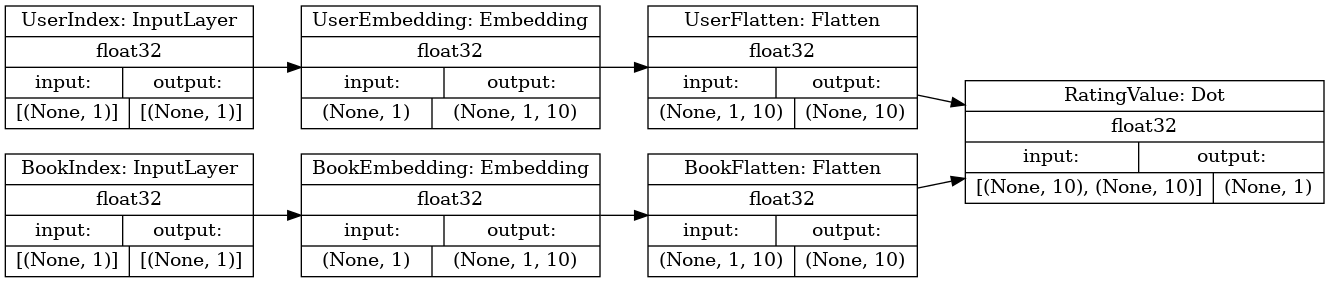

In [6]:
# Clear the global Keras state
tf.keras.backend.clear_session()

# Build a baseline model in GPU
with tf.device('/GPU:0'):
    gd_baseline = RecommenderGD(users_count=len(user_categories.categories),
                                books_count=len(item_categories.categories),
                                embed_size=10, random_seed=RANDOM_SEED)

# Show its structure
tf.keras.utils.plot_model(gd_baseline.build_graph(),
                          to_file='pics/recommender_gd.png',
                          show_shapes=True, show_dtype=True,
                          show_layer_names=True, rankdir='LR')

In [7]:
# To save the best weights
gd_model_path = os.path.join('trained_models', 'gd_baseline')
model_checkpoint = ModelCheckpoint(filepath=gd_model_path,      
                                   save_best_only=True,
                                   save_weights_obnly=True)

# Train the model
with tf.device('/GPU:0'):
    gd_baseline.compile(loss=tf.keras.losses.Huber(),
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    gd_baseline.fit(x=[work_ratings_train['user_id'].cat.codes.values,
                       work_ratings_train['work_id'].cat.codes.values],
                    y=work_ratings_train['rating_scaled'].values,
                    validation_data=([work_ratings_val['user_id'].cat.codes.values,
                                      work_ratings_val['work_id'].cat.codes.values],
                                     work_ratings_val['rating_scaled'].values),
                    callbacks=[model_checkpoint],
                    batch_size=1024, epochs=5, verbose=1);
    
    # Load the best weights
    gd_baseline.load_weights(gd_model_path)

Epoch 1/5
52188/52188 [==============================] - 356s 7ms/step - loss: 0.3907 - root_mean_squared_error: 0.9661 - val_loss: 0.3882 - val_root_mean_squared_error: 0.9837
INFO:tensorflow:Assets written to: trained_models/gd_baseline/assets
Epoch 2/5
52188/52188 [==============================] - 352s 7ms/step - loss: 0.3566 - root_mean_squared_error: 0.9237 - val_loss: 0.3822 - val_root_mean_squared_error: 0.9774
INFO:tensorflow:Assets written to: trained_models/gd_baseline/assets
Epoch 3/5
52188/52188 [==============================] - 352s 7ms/step - loss: 0.3390 - root_mean_squared_error: 0.9007 - val_loss: 0.3840 - val_root_mean_squared_error: 0.9807
Epoch 4/5
52188/52188 [==============================] - 359s 7ms/step - loss: 0.3284 - root_mean_squared_error: 0.8866 - val_loss: 0.3869 - val_root_mean_squared_error: 0.9856
Epoch 5/5
52188/52188 [==============================] - 364s 7ms/step - loss: 0.3213 - root_mean_squared_error: 0.8770 - val_loss: 0.3899 - val_root_mean

In [8]:
# Evaluate 
train_metrics = gd_baseline.evaluate((work_ratings_train['user_id'].cat.codes,
                                      work_ratings_train['work_id'].cat.codes),
                                     work_ratings_train[['rating_scaled']],
                                     return_dict=True, batch_size=4096)
val_metrics = gd_baseline.evaluate((work_ratings_val['user_id'].cat.codes,
                                    work_ratings_val['work_id'].cat.codes),
                                   work_ratings_val[['rating_scaled']],
                                   return_dict=True, batch_size=4096)

print(f'RMSE on the train data: {train_metrics["root_mean_squared_error"]}')
print(f'RMSE on the validation data: {val_metrics["root_mean_squared_error"]}')

4328/4328 [==============================] - 6s 1ms/step - loss: 0.3822 - root_mean_squared_error: 0.9774
RMSE on the train data: 0.8864442706108093
RMSE on the validation data: 0.9773859977722168


These results are better than from the SVD baseline. However, this approach also suffers from fast overfitting, so it demands regularization.